In [47]:
######## MODULES ##########
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.constants import c as C
from scipy import optimize as spopt
import celia_functions as cf
plt.rcParams.update({'font.size':18, "xtick.direction":"in", "ytick.direction":"in", "xtick.top": True, "ytick.right": True, "figure.figsize": [12, 8], "xtick.major.size": 7, "ytick.major.size": 7, "xtick.minor.size": 4, "ytick.minor.size": 4})
pd.set_option('display.max_rows', 50)
#np.set_printoptions(threshold=sys.maxsize)

In [48]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': ['-layers', 'OptimizePlus'],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'b

In [49]:
shotsheet = cf.read_metadata(["SHOT #","Pyro Ch2 filter (THz)","Pyro Ch3 filter (THz)","laser focus correction (mm)","Target X","Target Z","TARGET NUMBER","Laser Energy (before comp) [J]"])
targetsheet = cf.read_metadata(["Number","Wheel","Thickness (um)","Length(mm)","Material","Type"])

shotsheet = pd.DataFrame(shotsheet)
targetsheet = pd.DataFrame(targetsheet)

to_numeric = lambda series: pd.to_numeric(series, errors= "coerce") # pd.to_numeric works on pd.series but not on pd.DataFrames
shotsheet[["Target X", "Target Z"]] = shotsheet[["Target X", "Target Z"]] .apply(to_numeric) 
shotsheet.dropna(how= "all", inplace= True) # last row has no data! Remove it.

shotsheet = shotsheet.merge(targetsheet, how= "left", left_on= "TARGET NUMBER", right_on= "Number") # merge the targetsheet with the shotsheet
shotsheet.drop("Number", axis= 1, inplace= True)

shotsheet.describe()

,SHOT #,laser focus correction (mm),Target X,Target Z,TARGET NUMBER,Wheel,Thickness (um),Length(mm)
count,266.000000,198.000000,234.000000,234.000000,266.000000,266.000000,266.000000,266.000000
mean,132.661654,0.546490,3.552863,6.181303,68.000000,4.409774,264.097744,8.300752
std,76.697139,0.259477,1.382375,0.950730,37.500893,1.806001,397.911451,1.228498
min,1.000000,-0.150000,0.705000,3.195000,1.000000,1.000000,25.000000,4.000000
25%,66.250000,0.600000,2.475000,5.590000,33.750000,3.000000,50.000000,8.000000
50%,132.500000,0.600000,3.395000,6.170000,69.000000,4.000000,50.000000,8.000000
75%,198.750000,0.600000,4.511250,6.790000,104.750000,6.000000,50.000000,8.000000
max,265.000000,2.200000,6.985000,8.815000,125.000000,7.000000,1000.000000,10.000000


In [50]:
shotsheet["relative X"] = shotsheet.groupby('TARGET NUMBER')['Target X'].transform(lambda x: x -x.iloc[0]) #calculate the relitive movement from the first shot.
shotsheet["relative Z"] = shotsheet.groupby('TARGET NUMBER')['Target Z'].transform(lambda x: x -x.iloc[0])
shotsheet["nth shot on target"] = shotsheet.groupby('TARGET NUMBER')["TARGET NUMBER"].transform(lambda series: np.arange(len(series)) +1) #add a column that counts how many times the target has been shot.

shotsheet["d"] = np.linalg.norm(shotsheet[["relative X", "relative Z"]], axis= 1) # pythagorus to find d. This might be a little simplistic since we know the angle should be 25°

# Apply filters
shotsheet = shotsheet[shotsheet["laser focus correction (mm)"] == 0.6]
shotsheet = shotsheet[shotsheet["Length(mm)"] == 8]
shotsheet = shotsheet[shotsheet["Material"] == "Cu"]
shotsheet = shotsheet[shotsheet["Type"] == "wire"]

shotsheet.describe()

,SHOT #,laser focus correction (mm),Target X,Target Z,TARGET NUMBER,Wheel,Thickness (um),Length(mm),relative X,relative Z,nth shot on target,d
count,115.000000,1.150000e+02,111.000000,111.000000,115.000000,115.000000,115.0,115.0,111.000000,111.00000,115.000000,111.000000
mean,178.373913,6.000000e-01,3.121532,5.901559,93.339130,5.469565,50.0,8.0,1.219820,0.64518,3.695652,1.399945
std,48.426189,2.230164e-16,1.016676,0.773292,18.875812,1.078675,0.0,0.0,0.998551,0.51719,2.165008,1.099298
min,99.000000,6.000000e-01,0.795000,3.195000,60.000000,4.000000,50.0,8.0,0.000000,0.00000,1.000000,0.000000
25%,133.500000,6.000000e-01,2.390000,5.495000,69.000000,4.000000,50.0,8.0,0.400000,0.24000,2.000000,0.477924
50%,182.000000,6.000000e-01,3.005000,5.950000,104.000000,6.000000,50.0,8.0,1.000000,0.60000,3.000000,1.346143
75%,226.500000,6.000000e-01,3.835000,6.430000,108.500000,6.000000,50.0,8.0,1.925000,0.99500,5.000000,2.166781
max,258.000000,6.000000e-01,5.495000,7.650000,116.000000,7.000000,50.0,8.0,3.500000,2.32500,9.000000,3.908657


### Choose which targets and channels to use here!

In [51]:
pyro_background = {"Ch1": [99,100,101,102,104,105,107,108,109,110,111,112,113,154,155,156,157,158,159,160,161,162,163,164,165,166,168,169,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,214,215,216,217,218,219,220,221,222,223,224,225,226,227,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265],
                   "Ch2": [114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153],
                   "Ch3": [70,71,72,74,75,76,77,78,79,80,83,84,85,86,87,88,89,92,93,94,95,96,97,98]}

diagnostics = {"Ch2": [158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,211,214,215,216,217,218,219,220,221,222,223,224,225,225,226,227,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246],
               "Ch3": [138,139,140,141,142,143,144,145,147,148,149,150,151,152,153,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196],
               "bdot": shotsheet["SHOT #"],
               "xray": shotsheet["SHOT #"],
               "energy": shotsheet["SHOT #"]}

diagnostics_functions = {"Ch1": lambda x: x,
                         "Ch2": lambda x: x,
                         "Ch3": lambda x: x,
                         "Ch4": lambda x: x,
                         "bdot": lambda x: np.ma.masked_invalid(x).ptp(),
                         "tof": np.ptp,
                         "diode": np.ptp,
                         "xray": cf.estimate_xray_signal,
                         "energy": lambda x: x}

diagnostic_data = cf.read_diagnostic_data(diagnostics, functions= diagnostics_functions, silent= False)
diagnostic_data = pd.DataFrame(diagnostic_data)

background_data = cf.read_diagnostic_data(pyro_background, functions= diagnostics_functions, silent= False)
background_data = pd.DataFrame(background_data)

background_lookup = pd.DataFrame(([shot, ch, cf.flatten_list(background_data[ch][background_data["shot"] == shot].values)] for ch, shots in pyro_background.items() for shot in shots), columns= ["shot", "bg channel", "bg data"]) #Create a dataframe with the bg data

Found 82 files:
   290124WIRESHOT158000_Ch2.csv
   290124WIRESHOT159000_Ch2.csv
   290124WIRESHOT160000_Ch2.csv
   290124WIRESHOT161000_Ch2.csv
   290124WIRESHOT162000_Ch2.csv
   290124WIRESHOT163000_Ch2.csv
   290124WIRESHOT164000_Ch2.csv
   290124WIRESHOT165000_Ch2.csv
   290124WIRESHOT166000_Ch2.csv
   290124WIRESHOT169000_Ch2.csv
   290124WIRESHOT167000_Ch2.csv
   290124WIRESHOT168000_Ch2.csv
   290124WIRESHOT222000_Ch2.csv
   290124WIRESHOT223000_Ch2.csv
   290124WIRESHOT224000_Ch2.csv
   290124WIRESHOT225000_Ch2.csv
   290124WIRESHOT226000_Ch2.csv
   290124WIRESHOT174000_Ch2.csv
   290124WIRESHOT175000_Ch2.csv
   290124WIRESHOT176000_Ch2.csv
   290124WIRESHOT177000_Ch2.csv
   290124WIRESHOT178000_Ch2.csv
   290124WIRESHOT179000_Ch2.csv
   290124WIRESHOT180000_Ch2.csv
   290124WIRESHOT181000_Ch2.csv
   290124WIRESHOT182000_Ch2.csv
   290124WIRESHOT183000_Ch2.csv
   290124WIRESHOT184000_Ch2.csv
   290124WIRESHOT185000_Ch2.csv
   290124WIRESHOT186000_Ch2.csv
   290124WIRESHOT187000_

In [52]:
pyro_channels_to_bg_subtract = ["Ch1","Ch2","Ch3"]
pyro_channels = ["Ch1","Ch2","Ch3","Ch4"] # Establishing a catagory of diagnostics will be helpful later.

pyro_channels = np.intersect1d(pyro_channels, list(diagnostic_data.keys())) # useful to know which pyro channels to analysise and plot
pyro_channels_to_bg_subtract = np.intersect1d(pyro_channels_to_bg_subtract, list(diagnostic_data.keys())) 

diagnostic_data = diagnostic_data.merge(background_lookup, how= "left", on= "shot") # add the background infomation to the shotsheet
diagnostic_data["bg data"].fillna(0, inplace= True) # Sometimes the background was not measured

C:\Users\syf83691\AppData\Local\Temp\ipykernel_7592\2945668715.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  diagnostic_data["bg data"].fillna(0, inplace= True) # Sometimes the background was not measured


In [53]:
for ch in pyro_channels_to_bg_subtract:
    diagnostic_data[ch] = diagnostic_data[ch] -diagnostic_data["bg data"]

diagnostic_data.drop("bg data", axis= 1, inplace= True) # The background data is no longer needed now that we have finished background subtraction.

diagnostic_data.describe()

,shot,bdot,xray,energy
count,139.000000,111.000000,93.000000,1.110000e+02
mean,179.438849,0.692523,957.741935,1.213459e-06
std,45.321575,0.141400,370.300793,3.811938e-07
min,99.000000,0.265430,6.000000,1.370000e-07
25%,139.500000,0.591691,750.500000,1.010000e-06
50%,179.000000,0.709781,965.000000,1.190000e-06
75%,220.500000,0.784469,1176.500000,1.460000e-06
max,258.000000,1.010719,1685.500000,2.080000e-06


In [54]:
find_minima = lambda x: np.abs(np.nanmin(x))
diagnostic_data[pyro_channels] = diagnostic_data[pyro_channels].map(find_minima, na_action= "ignore") # find the minima of every pyro channel. df.map applies the function element-wise rather than row or column-wise

shotsheet = shotsheet.merge(diagnostic_data, how= "left", left_on= "SHOT #", right_on= "shot") #merge with shotsheet
shotsheet.drop("shot", axis= 1, inplace= True)

shotsheet.describe()

,SHOT #,laser focus correction (mm),Target X,Target Z,TARGET NUMBER,Wheel,Thickness (um),Length(mm),relative X,relative Z,nth shot on target,d,Ch2,Ch3,bdot,xray,energy
count,115.000000,1.150000e+02,111.000000,111.000000,115.000000,115.000000,115.0,115.0,111.000000,111.00000,115.000000,111.000000,56.000000,38.000000,111.000000,93.000000,1.110000e+02
mean,178.373913,6.000000e-01,3.121532,5.901559,93.339130,5.469565,50.0,8.0,1.219820,0.64518,3.695652,1.399945,0.984000,1.315263,0.692523,957.741935,1.213459e-06
std,48.426189,2.230164e-16,1.016676,0.773292,18.875812,1.078675,0.0,0.0,0.998551,0.51719,2.165008,1.099298,1.070113,0.955026,0.141400,370.300793,3.811938e-07
min,99.000000,6.000000e-01,0.795000,3.195000,60.000000,4.000000,50.0,8.0,0.000000,0.00000,1.000000,0.000000,0.096000,0.120000,0.265430,6.000000,1.370000e-07
25%,133.500000,6.000000e-01,2.390000,5.495000,69.000000,4.000000,50.0,8.0,0.400000,0.24000,2.000000,0.477924,0.320000,0.410000,0.591691,750.500000,1.010000e-06
50%,182.000000,6.000000e-01,3.005000,5.950000,104.000000,6.000000,50.0,8.0,1.000000,0.60000,3.000000,1.346143,0.520000,1.280000,0.709781,965.000000,1.190000e-06
75%,226.500000,6.000000e-01,3.835000,6.430000,108.500000,6.000000,50.0,8.0,1.925000,0.99500,5.000000,2.166781,1.360000,1.880000,0.784469,1176.500000,1.460000e-06
max,258.000000,6.000000e-01,5.495000,7.650000,116.000000,7.000000,50.0,8.0,3.500000,2.32500,9.000000,3.908657,5.000000,4.160000,1.010719,1685.500000,2.080000e-06


In [55]:
diags = list(diagnostics)

#shotsheet[diags] = (shotsheet[diags].values.T /shotsheet["Laser Energy (before comp) [J]"].values).T # normalise for laser energy
#shotsheet[diags] = shotsheet.groupby('TARGET NUMBER')[diags].transform(lambda x: x /x.iloc[0]) # normalise to first shot on target
#shotsheet[diags] = shotsheet[diags] /shotsheet[diags].mean()
shotsheet = shotsheet.replace([-np.inf, np.inf], np.nan) # infs are invalid. I think there were some div 0 errors when normalising to the first shot on target.

shotsheet.describe()

C:\Users\syf83691\AppData\Local\Temp\ipykernel_7592\3495854346.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  shotsheet = shotsheet.replace([-np.inf, np.inf], np.nan) # infs are invalid. I think there were some div 0 errors when normalising to the first shot on target.


,SHOT #,laser focus correction (mm),Target X,Target Z,TARGET NUMBER,Laser Energy (before comp) [J],Wheel,Thickness (um),Length(mm),relative X,relative Z,nth shot on target,d,Ch2,Ch3,bdot,xray,energy
count,115.000000,1.150000e+02,111.000000,111.000000,115.000000,115.000000,115.000000,115.0,115.0,111.000000,111.00000,115.000000,111.000000,56.000000,38.000000,111.000000,93.000000,1.110000e+02
mean,178.373913,6.000000e-01,3.121532,5.901559,93.339130,0.880513,5.469565,50.0,8.0,1.219820,0.64518,3.695652,1.399945,0.984000,1.315263,0.692523,957.741935,1.213459e-06
std,48.426189,2.230164e-16,1.016676,0.773292,18.875812,0.103609,1.078675,0.0,0.0,0.998551,0.51719,2.165008,1.099298,1.070113,0.955026,0.141400,370.300793,3.811938e-07
min,99.000000,6.000000e-01,0.795000,3.195000,60.000000,0.609000,4.000000,50.0,8.0,0.000000,0.00000,1.000000,0.000000,0.096000,0.120000,0.265430,6.000000,1.370000e-07
25%,133.500000,6.000000e-01,2.390000,5.495000,69.000000,0.820000,4.000000,50.0,8.0,0.400000,0.24000,2.000000,0.477924,0.320000,0.410000,0.591691,750.500000,1.010000e-06
50%,182.000000,6.000000e-01,3.005000,5.950000,104.000000,0.894000,6.000000,50.0,8.0,1.000000,0.60000,3.000000,1.346143,0.520000,1.280000,0.709781,965.000000,1.190000e-06
75%,226.500000,6.000000e-01,3.835000,6.430000,108.500000,0.958000,6.000000,50.0,8.0,1.925000,0.99500,5.000000,2.166781,1.360000,1.880000,0.784469,1176.500000,1.460000e-06
max,258.000000,6.000000e-01,5.495000,7.650000,116.000000,1.080000,7.000000,50.0,8.0,3.500000,2.32500,9.000000,3.908657,5.000000,4.160000,1.010719,1685.500000,2.080000e-06


In [56]:
shotsheet["target desc"] = ["{0:.0f}mm {1:} {2:}".format(length, material, ttype)
                            for length, material, ttype
                            in zip(shotsheet["Length(mm)"], shotsheet["Material"], shotsheet["Type"])]

shotsheet["target desc"].unique() #The target description combines the length, material and type of target.

array(['8mm Cu wire'], dtype=object)

### Setup parameters for graph

In [57]:
shotsheet.columns

Index(['SHOT #', 'Pyro Ch2 filter (THz)', 'Pyro Ch3 filter (THz)',
       'laser focus correction (mm)', 'Target X', 'Target Z', 'TARGET NUMBER',
       'Laser Energy (before comp) [J]', 'Wheel', 'Thickness (um)',
       'Length(mm)', 'Material', 'Type', 'relative X', 'relative Z',
       'nth shot on target', 'd', 'Ch2', 'Ch3', 'bdot', 'xray', 'energy',
       'bg channel', 'target desc'],
      dtype='object')

In [58]:
formatting = {"Ch2": {"colour": "tab:red", "marker": "o"},
              "Ch3": {"colour": "tab:orange", "marker": "^"}}

In [77]:
shotsheet["Pyro Ch2 filter (THz)"].apply(to_numeric).max()

30.0

In [78]:
shotsheet["Pyro Ch2 filter (THz)"].apply(to_numeric).min()

0.31

In [79]:
shotsheet["Pyro Ch3 filter (THz)"].apply(to_numeric).max()

30.0

In [80]:
shotsheet["Pyro Ch3 filter (THz)"].apply(to_numeric).min()

0.7

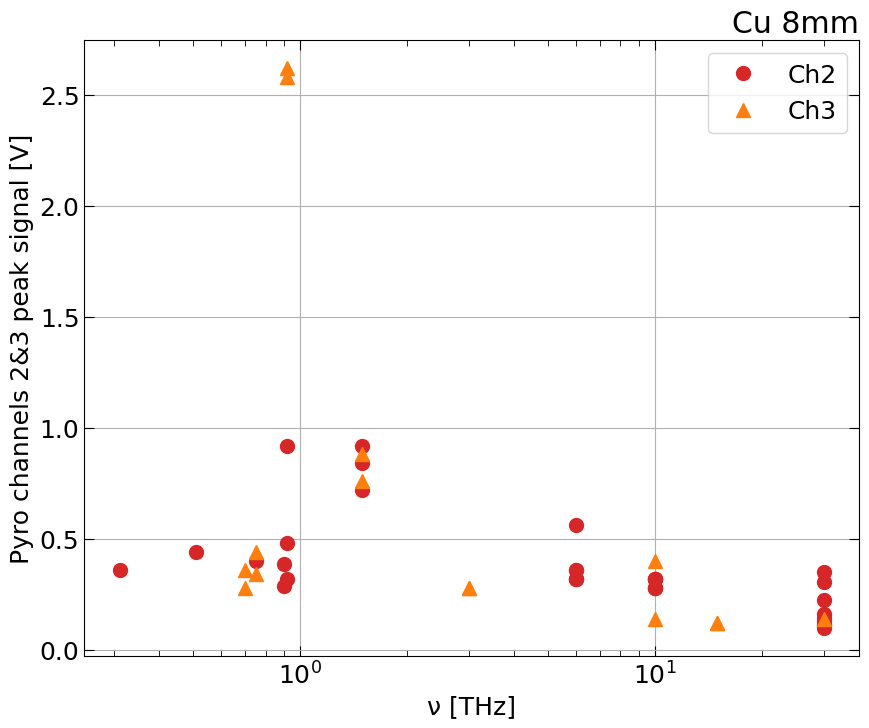

In [72]:
fig, axs = plt.subplots(1, 1, figsize= (10, 8))

for channel in formatting:
    xaxis = "Pyro {0:} filter (THz)".format(channel)

    means = shotsheet.groupby(xaxis)[channel].transform("mean")
    maxs = shotsheet.groupby(xaxis)[channel].transform("max") -means
    mins = means -shotsheet.groupby(xaxis)[channel].transform("min")

    axs.plot(shotsheet[xaxis].apply(to_numeric), shotsheet[channel], color= formatting[channel]["colour"], marker= formatting[channel]["marker"], markersize= 10, linestyle= "none", label= channel)
    #axs.errorbar(shotsheet[xaxis].apply(to_numeric), means, yerr= (mins, maxs), color= formatting[channel]["colour"], marker= formatting[channel]["marker"], markersize= 10, linestyle= "none", label= channel)

axs.legend()
axs.set(xlabel= "ν [THz]", ylabel= "Pyro channels 2&3 peak signal [V]", xscale= "log")
axs.set_title("Cu 8mm", loc= "right")
axs.grid()

plt.show()

In [60]:
def line(x, m, c):
    return m*x +c

popt, pcov= {}, {}
for channel in formatting:
    filters = "Pyro {0:} filter (THz)".format(channel)
    xdata = 8-shotsheet["d"]
    ydata = shotsheet[channel].where(shotsheet[filters].apply(type) == str)
    is_valid = ~np.logical_or(np.isnan(xdata), np.isnan(ydata))

    popt[channel], pcov[channel] = spopt.curve_fit(line, xdata[is_valid], ydata[is_valid], method= "trf", loss= "cauchy") #scipy curvefit only raises an error if the y data has nans. It doesn't check the x data.

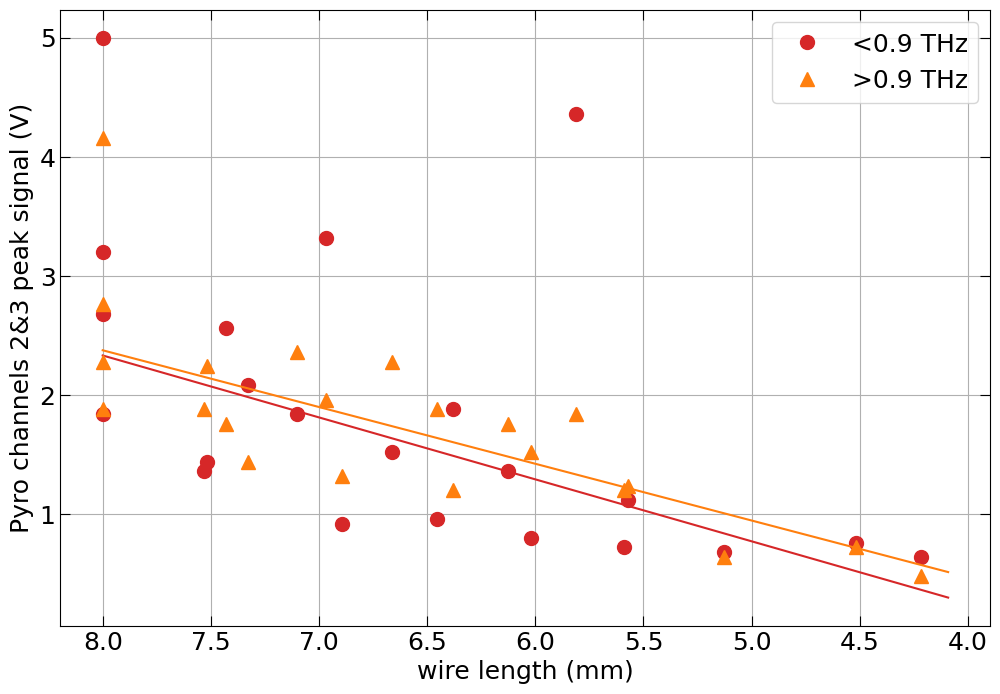

In [88]:
fig, axs = plt.subplots(1, 1, figsize= (12, 8))

for channel in formatting:
    filters = "Pyro {0:} filter (THz)".format(channel)
    xdata = 8-shotsheet["d"]
    ydata = shotsheet[channel].where(shotsheet[filters].apply(type) == str)
    bandpass = shotsheet[filters].loc[shotsheet[filters].apply(type) == str].iloc[0]

    x = np.linspace(np.nanmin(xdata), np.nanmax(xdata), 100, endpoint= True)

    axs.plot(xdata, ydata, color= formatting[channel]["colour"], marker= formatting[channel]["marker"], markersize= 10, linestyle= "none", label= "{0:} THz".format(bandpass))
    axs.plot(x, line(x, *popt[channel]) ,color= formatting[channel]["colour"])

axs.legend()
axs.set(xlabel= "wire length (mm)", ylabel= "Pyro channels 2&3 peak signal (V)")
axs.grid()
axs.invert_xaxis()

plt.show()